<a href="https://colab.research.google.com/github/swapniel99/erav1s8/blob/develop/S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/swapniel99/erav1s8.git
%cd erav1s8/
!git checkout develop
!git pull
%ls

Cloning into 'erav1s8'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 93 (delta 50), reused 58 (delta 23), pack-reused 0
Unpacking objects: 100% (93/93), 1.63 MiB | 5.58 MiB/s, done.
/content/erav1s8
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
Already up to date.
backprop.py  ghostbn.py  README.md         S8.ipynb
datasets/    model.py    requirements.txt  utils.py


In [3]:
from utils import *
set_seed(42)

Device Selected: cuda


In [4]:
from datasets import CIFAR10
batch_size = 32
cifar10 = CIFAR10(batch_size)

100%|██████████| 170498071/170498071 [00:01<00:00, 103677966.12it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


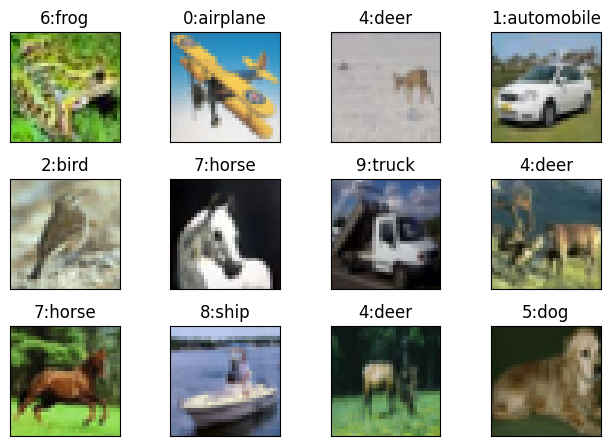

In [5]:
cifar10.show_examples()

In [6]:
from model import GroupNormModel, LayerNormModel, BatchNormModel
from backprop import Experiment

# Experiment 1: Group Normalisation

In [7]:
model1 = GroupNormModel(n_groups=4, skip=True, dropout=0.05)
model1.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
GroupNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─GroupNorm: 3-2               [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [8]:
exp1 = Experiment(model1, cifar10)
exp1.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.7283, Accuracy=35.31: 100%|██████████| 1563/1563 [00:30<00:00, 51.68it/s]


Test: Average loss: 1.4809, Accuracy: 44.75
Epoch 2


Train: Batch_id=1562, Average Loss=1.3410, Accuracy=50.95: 100%|██████████| 1563/1563 [00:30<00:00, 51.73it/s]


Test: Average loss: 1.2210, Accuracy: 56.04
Epoch 3


Train: Batch_id=1562, Average Loss=1.1715, Accuracy=57.44: 100%|██████████| 1563/1563 [00:28<00:00, 54.07it/s]


Test: Average loss: 1.0990, Accuracy: 60.29
Epoch 4


Train: Batch_id=1562, Average Loss=1.0521, Accuracy=62.35: 100%|██████████| 1563/1563 [00:30<00:00, 50.61it/s]


Test: Average loss: 0.9696, Accuracy: 65.19
Epoch 5


Train: Batch_id=1562, Average Loss=0.9793, Accuracy=65.03: 100%|██████████| 1563/1563 [00:29<00:00, 52.72it/s]


Test: Average loss: 0.9859, Accuracy: 65.48
Epoch 00005: reducing learning rate of group 0 to 5.0000e-03.
Epoch 6


Train: Batch_id=1562, Average Loss=0.8668, Accuracy=69.16: 100%|██████████| 1563/1563 [00:30<00:00, 51.54it/s]


Test: Average loss: 0.8625, Accuracy: 69.45
Epoch 7


Train: Batch_id=1562, Average Loss=0.8373, Accuracy=70.38: 100%|██████████| 1563/1563 [00:31<00:00, 50.08it/s]


Test: Average loss: 0.8390, Accuracy: 69.92
Epoch 8


Train: Batch_id=1562, Average Loss=0.8125, Accuracy=71.26: 100%|██████████| 1563/1563 [00:29<00:00, 52.58it/s]


Test: Average loss: 0.8021, Accuracy: 71.24
Epoch 9


Train: Batch_id=1562, Average Loss=0.7853, Accuracy=72.30: 100%|██████████| 1563/1563 [00:29<00:00, 52.54it/s]


Test: Average loss: 0.7740, Accuracy: 72.96
Epoch 10


Train: Batch_id=1562, Average Loss=0.7748, Accuracy=72.70: 100%|██████████| 1563/1563 [00:29<00:00, 52.25it/s]


Test: Average loss: 0.8507, Accuracy: 70.57
Epoch 00010: reducing learning rate of group 0 to 2.5000e-03.
Epoch 11


Train: Batch_id=1562, Average Loss=0.7127, Accuracy=75.04: 100%|██████████| 1563/1563 [00:29<00:00, 53.03it/s]


Test: Average loss: 0.7370, Accuracy: 74.64
Epoch 12


Train: Batch_id=1562, Average Loss=0.6995, Accuracy=75.59: 100%|██████████| 1563/1563 [00:30<00:00, 51.71it/s]


Test: Average loss: 0.7569, Accuracy: 73.54
Epoch 00012: reducing learning rate of group 0 to 1.2500e-03.
Epoch 13


Train: Batch_id=1562, Average Loss=0.6659, Accuracy=76.77: 100%|██████████| 1563/1563 [00:29<00:00, 52.96it/s]


Test: Average loss: 0.7398, Accuracy: 74.27
Epoch 00013: reducing learning rate of group 0 to 6.2500e-04.
Epoch 14


Train: Batch_id=1562, Average Loss=0.6477, Accuracy=77.43: 100%|██████████| 1563/1563 [00:29<00:00, 53.84it/s]


Test: Average loss: 0.7134, Accuracy: 75.31
Epoch 15


Train: Batch_id=1562, Average Loss=0.6450, Accuracy=77.43: 100%|██████████| 1563/1563 [00:29<00:00, 53.55it/s]


Test: Average loss: 0.7075, Accuracy: 75.34
Epoch 16


Train: Batch_id=1562, Average Loss=0.6388, Accuracy=77.76: 100%|██████████| 1563/1563 [00:29<00:00, 53.29it/s]


Test: Average loss: 0.7084, Accuracy: 75.81
Epoch 00016: reducing learning rate of group 0 to 3.1250e-04.
Epoch 17


Train: Batch_id=1562, Average Loss=0.6286, Accuracy=77.83: 100%|██████████| 1563/1563 [00:29<00:00, 52.52it/s]


Test: Average loss: 0.7009, Accuracy: 75.83
Epoch 18


Train: Batch_id=1562, Average Loss=0.6281, Accuracy=77.98: 100%|██████████| 1563/1563 [00:29<00:00, 53.11it/s]


Test: Average loss: 0.6939, Accuracy: 76.07
Epoch 19


Train: Batch_id=1562, Average Loss=0.6250, Accuracy=78.18: 100%|██████████| 1563/1563 [00:30<00:00, 50.92it/s]


Test: Average loss: 0.7035, Accuracy: 75.91
Epoch 00019: reducing learning rate of group 0 to 1.5625e-04.
Epoch 20


Train: Batch_id=1562, Average Loss=0.6210, Accuracy=78.23: 100%|██████████| 1563/1563 [00:29<00:00, 52.58it/s]


Test: Average loss: 0.6915, Accuracy: 76.33


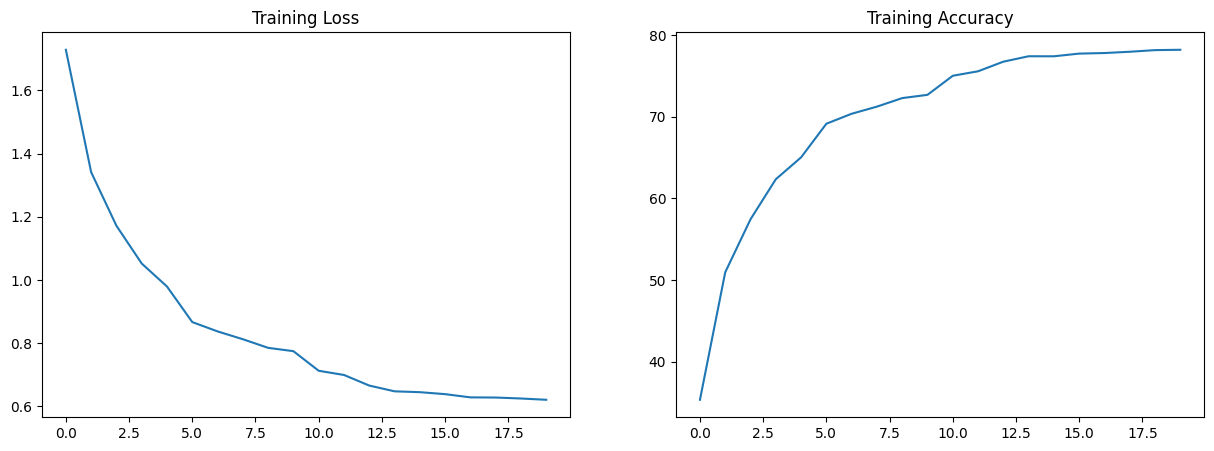

In [10]:
exp1.train.plot_stats()

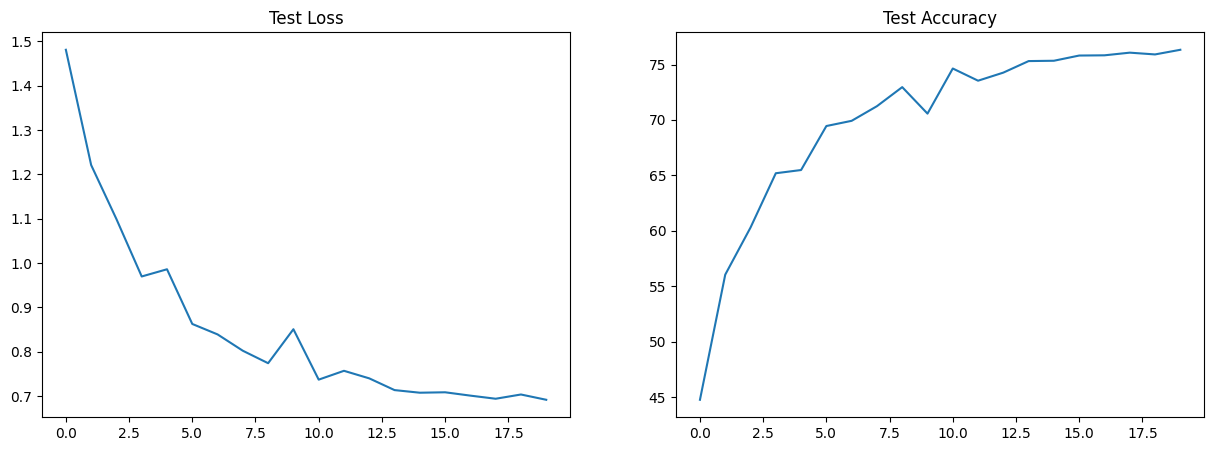

In [11]:
exp1.test.plot_stats()

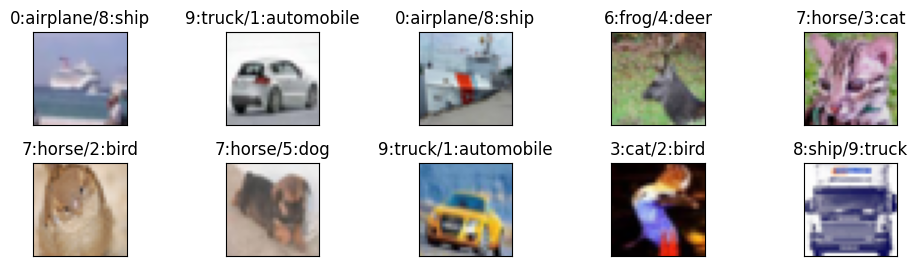

In [12]:
exp1.test.show_incorrect()

# Experiment 2: Layer Normalisation

In [13]:
model2 = LayerNormModel(skip=True, dropout=0.05)
model2.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
LayerNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─GroupNorm: 3-2               [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [14]:
exp2 = Experiment(model2, cifar10)
exp2.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.8162, Accuracy=31.73: 100%|██████████| 1563/1563 [00:29<00:00, 52.70it/s]


Test: Average loss: 1.6390, Accuracy: 38.42
Epoch 2


Train: Batch_id=1562, Average Loss=1.4500, Accuracy=46.63: 100%|██████████| 1563/1563 [00:29<00:00, 53.11it/s]


Test: Average loss: 1.2653, Accuracy: 54.39
Epoch 3


Train: Batch_id=1562, Average Loss=1.2667, Accuracy=53.90: 100%|██████████| 1563/1563 [00:28<00:00, 54.00it/s]


Test: Average loss: 1.2475, Accuracy: 53.93
Epoch 4


Train: Batch_id=1562, Average Loss=1.1583, Accuracy=58.05: 100%|██████████| 1563/1563 [00:29<00:00, 53.24it/s]


Test: Average loss: 1.1149, Accuracy: 60.16
Epoch 5


Train: Batch_id=1562, Average Loss=1.0715, Accuracy=61.59: 100%|██████████| 1563/1563 [00:29<00:00, 53.53it/s]


Test: Average loss: 1.0443, Accuracy: 62.73
Epoch 6


Train: Batch_id=1562, Average Loss=1.0021, Accuracy=64.21: 100%|██████████| 1563/1563 [00:30<00:00, 52.10it/s]


Test: Average loss: 0.9681, Accuracy: 65.53
Epoch 7


Train: Batch_id=1562, Average Loss=0.9489, Accuracy=66.09: 100%|██████████| 1563/1563 [00:29<00:00, 53.11it/s]


Test: Average loss: 0.9793, Accuracy: 65.52
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.
Epoch 8


Train: Batch_id=1562, Average Loss=0.8465, Accuracy=69.95: 100%|██████████| 1563/1563 [00:29<00:00, 52.92it/s]


Test: Average loss: 0.8503, Accuracy: 69.54
Epoch 9


Train: Batch_id=1562, Average Loss=0.8144, Accuracy=71.22: 100%|██████████| 1563/1563 [00:28<00:00, 53.95it/s]


Test: Average loss: 0.8135, Accuracy: 71.07
Epoch 10


Train: Batch_id=1562, Average Loss=0.7991, Accuracy=71.74: 100%|██████████| 1563/1563 [00:28<00:00, 54.25it/s]


Test: Average loss: 0.8394, Accuracy: 70.41
Epoch 00010: reducing learning rate of group 0 to 2.5000e-03.
Epoch 11


Train: Batch_id=1562, Average Loss=0.7444, Accuracy=73.81: 100%|██████████| 1563/1563 [00:29<00:00, 53.02it/s]


Test: Average loss: 0.7600, Accuracy: 72.82
Epoch 12


Train: Batch_id=1562, Average Loss=0.7274, Accuracy=74.34: 100%|██████████| 1563/1563 [00:29<00:00, 53.52it/s]


Test: Average loss: 0.7731, Accuracy: 72.62
Epoch 00012: reducing learning rate of group 0 to 1.2500e-03.
Epoch 13


Train: Batch_id=1562, Average Loss=0.7008, Accuracy=75.28: 100%|██████████| 1563/1563 [00:30<00:00, 52.00it/s]


Test: Average loss: 0.7527, Accuracy: 73.36
Epoch 14


Train: Batch_id=1562, Average Loss=0.6940, Accuracy=75.71: 100%|██████████| 1563/1563 [00:29<00:00, 53.59it/s]


Test: Average loss: 0.7333, Accuracy: 74.29
Epoch 15


Train: Batch_id=1562, Average Loss=0.6872, Accuracy=75.77: 100%|██████████| 1563/1563 [00:29<00:00, 52.65it/s]


Test: Average loss: 0.7554, Accuracy: 73.49
Epoch 00015: reducing learning rate of group 0 to 6.2500e-04.
Epoch 16


Train: Batch_id=1562, Average Loss=0.6675, Accuracy=76.56: 100%|██████████| 1563/1563 [00:29<00:00, 53.42it/s]


Test: Average loss: 0.7230, Accuracy: 74.53
Epoch 17


Train: Batch_id=1562, Average Loss=0.6679, Accuracy=76.52: 100%|██████████| 1563/1563 [00:29<00:00, 53.45it/s]


Test: Average loss: 0.7294, Accuracy: 74.28
Epoch 00017: reducing learning rate of group 0 to 3.1250e-04.
Epoch 18


Train: Batch_id=1562, Average Loss=0.6540, Accuracy=76.97: 100%|██████████| 1563/1563 [00:29<00:00, 53.63it/s]


Test: Average loss: 0.7199, Accuracy: 74.69
Epoch 19


Train: Batch_id=1562, Average Loss=0.6546, Accuracy=77.04: 100%|██████████| 1563/1563 [00:29<00:00, 53.72it/s]


Test: Average loss: 0.7180, Accuracy: 74.61
Epoch 20


Train: Batch_id=1562, Average Loss=0.6515, Accuracy=77.24: 100%|██████████| 1563/1563 [00:29<00:00, 52.96it/s]


Test: Average loss: 0.7125, Accuracy: 75.11


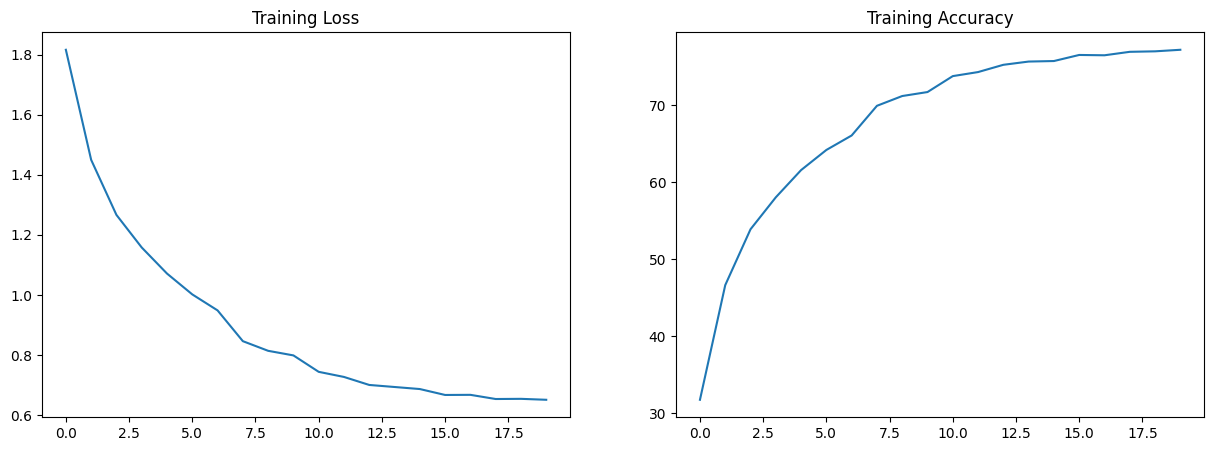

In [15]:
exp2.train.plot_stats()

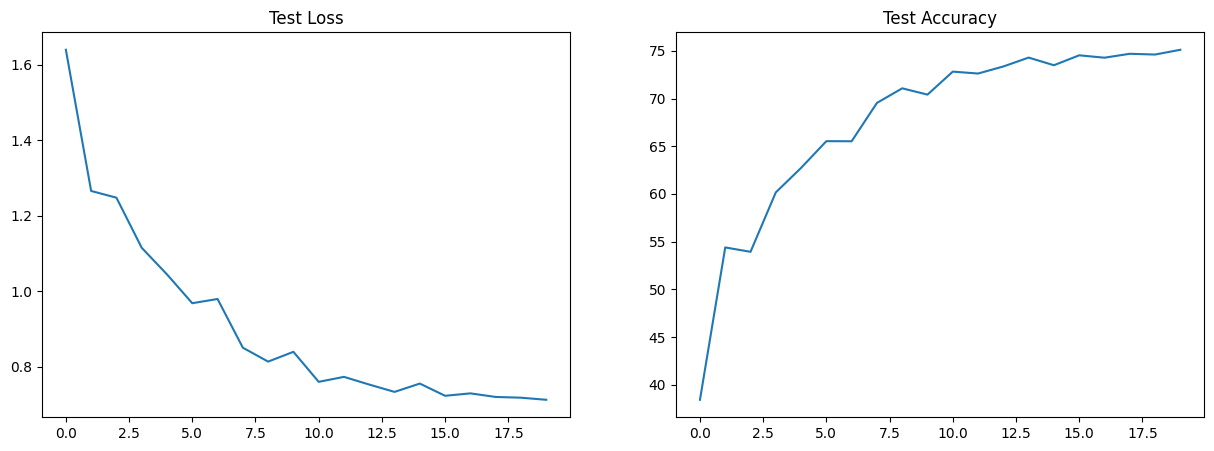

In [16]:
exp2.test.plot_stats()

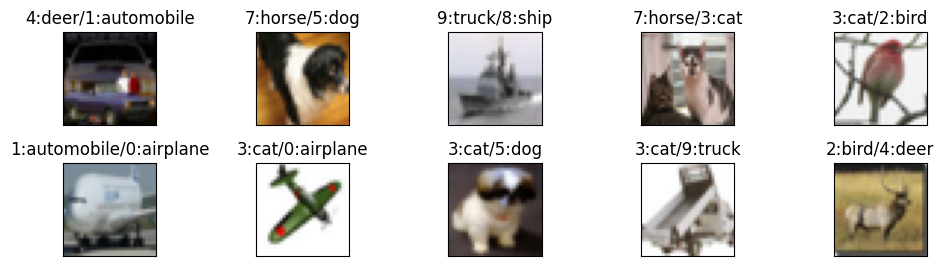

In [17]:
exp2.test.show_incorrect()

# Experiment 3: Batch Normalisation

In [18]:
model3 = BatchNormModel(skip=True, dropout=0.05)
model3.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
BatchNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─BatchNorm2d: 3-2             [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [19]:
exp3 = Experiment(model3, cifar10)
exp3.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.4661, Accuracy=45.98: 100%|██████████| 1563/1563 [00:29<00:00, 53.31it/s]


Test: Average loss: 1.5886, Accuracy: 46.34
Epoch 2


Train: Batch_id=1562, Average Loss=1.1414, Accuracy=59.11: 100%|██████████| 1563/1563 [00:28<00:00, 54.69it/s]


Test: Average loss: 1.0973, Accuracy: 61.39
Epoch 3


Train: Batch_id=1562, Average Loss=1.0245, Accuracy=63.59: 100%|██████████| 1563/1563 [00:28<00:00, 54.82it/s]


Test: Average loss: 0.9700, Accuracy: 64.59
Epoch 4


Train: Batch_id=1562, Average Loss=0.9448, Accuracy=66.76: 100%|██████████| 1563/1563 [00:28<00:00, 54.40it/s]


Test: Average loss: 0.9592, Accuracy: 66.22
Epoch 5


Train: Batch_id=1562, Average Loss=0.8852, Accuracy=68.82: 100%|██████████| 1563/1563 [00:29<00:00, 53.44it/s]


Test: Average loss: 0.8370, Accuracy: 70.19
Epoch 6


Train: Batch_id=1562, Average Loss=0.8449, Accuracy=70.17: 100%|██████████| 1563/1563 [00:29<00:00, 53.32it/s]


Test: Average loss: 0.7900, Accuracy: 71.82
Epoch 7


Train: Batch_id=1562, Average Loss=0.8055, Accuracy=71.62: 100%|██████████| 1563/1563 [00:28<00:00, 54.50it/s]


Test: Average loss: 0.8317, Accuracy: 70.18
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.
Epoch 8


Train: Batch_id=1562, Average Loss=0.7249, Accuracy=74.60: 100%|██████████| 1563/1563 [00:29<00:00, 53.51it/s]


Test: Average loss: 0.7221, Accuracy: 74.47
Epoch 9


Train: Batch_id=1562, Average Loss=0.7059, Accuracy=75.36: 100%|██████████| 1563/1563 [00:28<00:00, 54.68it/s]


Test: Average loss: 0.7244, Accuracy: 74.54
Epoch 00009: reducing learning rate of group 0 to 2.5000e-03.
Epoch 10


Train: Batch_id=1562, Average Loss=0.6670, Accuracy=76.57: 100%|██████████| 1563/1563 [00:29<00:00, 53.71it/s]


Test: Average loss: 0.6768, Accuracy: 76.49
Epoch 11


Train: Batch_id=1562, Average Loss=0.6515, Accuracy=77.13: 100%|██████████| 1563/1563 [00:28<00:00, 54.59it/s]


Test: Average loss: 0.6600, Accuracy: 76.90
Epoch 12


Train: Batch_id=1562, Average Loss=0.6462, Accuracy=77.39: 100%|██████████| 1563/1563 [00:29<00:00, 52.35it/s]


Test: Average loss: 0.6595, Accuracy: 76.92
Epoch 13


Train: Batch_id=1562, Average Loss=0.6411, Accuracy=77.62: 100%|██████████| 1563/1563 [00:28<00:00, 54.59it/s]


Test: Average loss: 0.6561, Accuracy: 76.83
Epoch 14


Train: Batch_id=1562, Average Loss=0.6311, Accuracy=77.75: 100%|██████████| 1563/1563 [00:29<00:00, 53.22it/s]


Test: Average loss: 0.6449, Accuracy: 77.27
Epoch 15


Train: Batch_id=1562, Average Loss=0.6271, Accuracy=78.14: 100%|██████████| 1563/1563 [00:28<00:00, 54.19it/s]


Test: Average loss: 0.6503, Accuracy: 77.16
Epoch 00015: reducing learning rate of group 0 to 1.2500e-03.
Epoch 16


Train: Batch_id=1562, Average Loss=0.6035, Accuracy=78.92: 100%|██████████| 1563/1563 [00:29<00:00, 53.22it/s]


Test: Average loss: 0.6286, Accuracy: 77.83
Epoch 17


Train: Batch_id=1562, Average Loss=0.5995, Accuracy=79.10: 100%|██████████| 1563/1563 [00:28<00:00, 54.60it/s]


Test: Average loss: 0.6242, Accuracy: 78.00
Epoch 18


Train: Batch_id=1562, Average Loss=0.5939, Accuracy=79.10: 100%|██████████| 1563/1563 [00:29<00:00, 52.90it/s]


Test: Average loss: 0.6247, Accuracy: 77.98
Epoch 00018: reducing learning rate of group 0 to 6.2500e-04.
Epoch 19


Train: Batch_id=1562, Average Loss=0.5775, Accuracy=79.99: 100%|██████████| 1563/1563 [00:28<00:00, 54.87it/s]


Test: Average loss: 0.6294, Accuracy: 77.82
Epoch 00019: reducing learning rate of group 0 to 3.1250e-04.
Epoch 20


Train: Batch_id=1562, Average Loss=0.5737, Accuracy=79.85: 100%|██████████| 1563/1563 [00:29<00:00, 53.05it/s]


Test: Average loss: 0.6145, Accuracy: 78.66


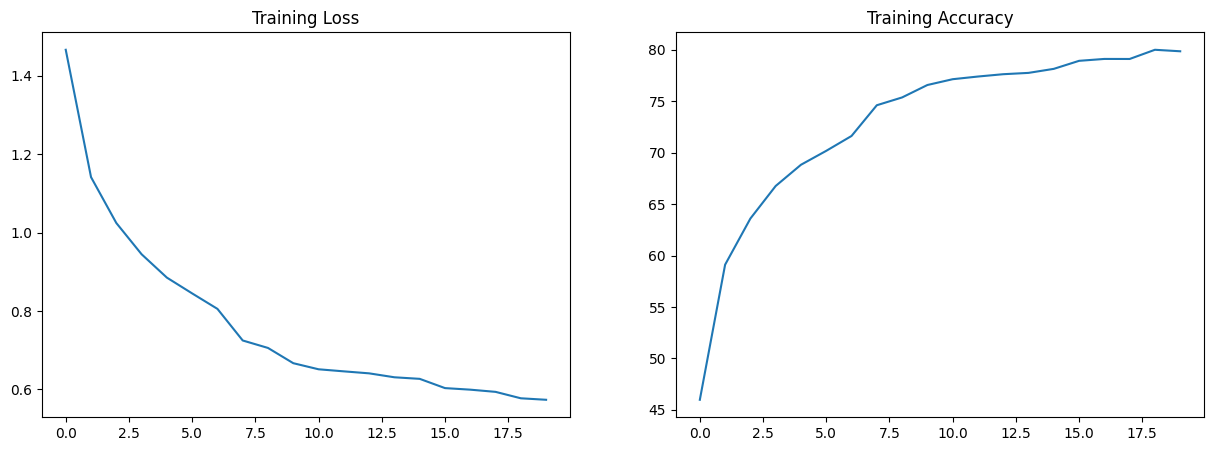

In [20]:
exp3.train.plot_stats()

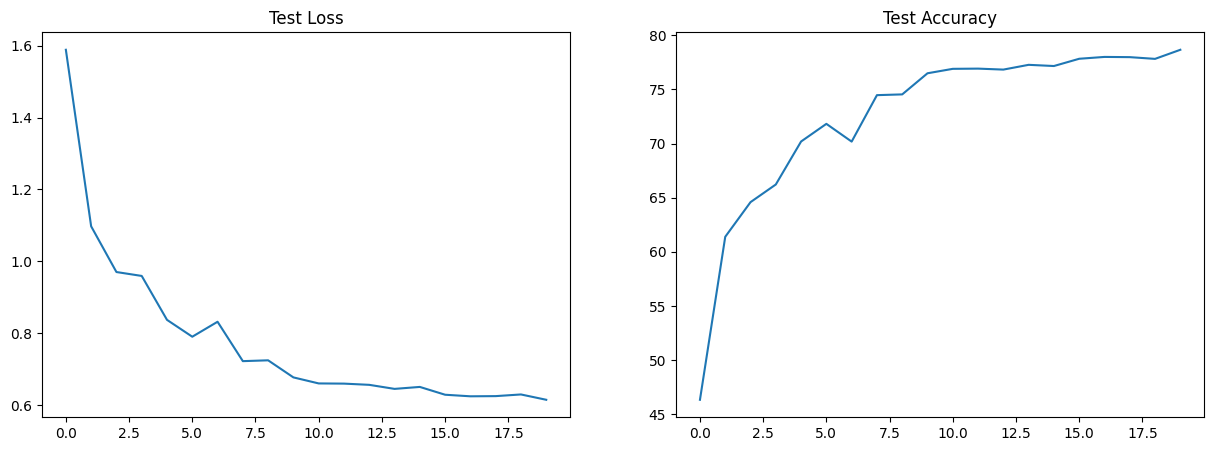

In [21]:
exp3.test.plot_stats()

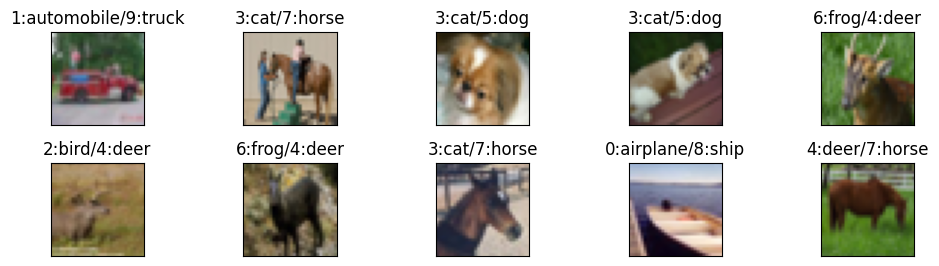

In [22]:
exp3.test.show_incorrect()